In [1]:
# =========================================================
# Apricity: A Personalized Mental Health Companion (Colab)
# - Emotion detection fine-tune (GoEmotions + BERT)
# - CBT-style supportive responses with FLAN-T5
# - Gradio demo
# =========================================================

!pip -q install transformers datasets accelerate evaluate gradio torch torchvision torchaudio --upgrade

import os, random, json, math
import numpy as np
import torch
from datasets import load_dataset, ClassLabel
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate
import gradio as gr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32

device(type='cuda')

In [2]:
# =========================================================
# 1) Load GoEmotions dataset
#    - 58k Reddit comments, 27 emotions + neutral
#    - multi-label; we'll convert to single-label via "primary" label for simplicity
#      (For research-grade, keep multi-label with sigmoid + BCEWithLogitsLoss)
# =========================================================

goemo = load_dataset("go_emotions")  # splits: train, validation, test
label_names = goemo["train"].features["labels"].feature.names
len(label_names), label_names[:10]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

(28,
 ['admiration',
  'amusement',
  'anger',
  'annoyance',
  'approval',
  'caring',
  'confusion',
  'curiosity',
  'desire',
  'disappointment'])

In [3]:
# =========================================================
# 2) Load GoEmotions dataset (Multi-Label RETAINED)
#    - We skip the single-label conversion to use the full data for higher accuracy.
# =========================================================

goemo = load_dataset("go_emotions")
label_names = goemo["train"].features["labels"].feature.names
num_labels = len(label_names) # 28
print(f"Total emotion classes retained: {num_labels}")

# Ensure any leftover 'primary' column from previous runs is removed
if "primary" in goemo["train"].column_names:
    goemo = goemo.remove_columns(["primary"])

print("Dataset is prepared for multi-label encoding.")

Total emotion classes retained: 28
Dataset is prepared for multi-label encoding.


In [4]:
# =========================================================
# 3) Load Model for Multi-Label & Tokenization
# =========================================================
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# --- CRITICAL CHANGE 1: Multi-Label Model Configuration ---
# Set problem_type to multi_label_classification (tells Trainer to use BCEWithLogitsLoss).
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label={i: label for i, label in enumerate(label_names)},
    label2id={label: i for i, label in enumerate(label_names)}
).to(device)
print(f"Model {MODEL_NAME} loaded for MULTI-LABEL classification.")

def tok_multi_label(batch):
    """Tokenizes text and creates the multi-hot encoded label vector (float)."""
    # 1. Tokenize the text (using max_length 192 as in your original code)
    tokenized_inputs = tokenizer(batch["text"], truncation=True, max_length=192)

    # 2. Create the multi-hot encoded label vector
    multi_hot_labels = []
    for label_list in batch["labels"]:
        # Initialize a vector of 0.0s (must be floats for BCEWithLogitsLoss)
        labels_vector = [0.0] * num_labels

        # Set 1.0 for all present label indices
        for label_idx in label_list:
            labels_vector[label_idx] = 1.0
        multi_hot_labels.append(labels_vector)

    # Explicitly convert the labels to torch.FloatTensor
    tokenized_inputs["labels"] = torch.FloatTensor(multi_hot_labels)
    return tokenized_inputs

# Map the new function
# We remove the original 'text' and 'labels' columns since we are replacing 'labels'
# with the multi-hot vector.
goemo_tok = goemo.map(tok_multi_label, batched=True, remove_columns=["text", "labels"])

# Set the format, ensuring 'labels' is a float tensor
# The explicit conversion in tok_multi_label should help, but keeping this
# ensures consistency.
goemo_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"], output_all_columns=True)
print("\nDataset tokenized and multi-hot encoded.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model bert-base-uncased loaded for MULTI-LABEL classification.


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]


Dataset tokenized and multi-hot encoded.


In [6]:
# =========================================================
# 4) Model, multi-label metrics, and Trainer setup
# =========================================================
from sklearn.metrics import f1_score, precision_recall_fscore_support
import numpy as np
from transformers import DataCollatorWithPadding
import torch

# Note: No need to load evaluate.load("accuracy") for multi-label

def compute_metrics(eval_pred):
    """Computes metrics for multi-label classification using a 0.5 threshold."""
    logits, labels = eval_pred

    # Explicitly convert NumPy arrays to PyTorch tensors with float type
    logits_tensor = torch.tensor(logits, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)


    # 1. Convert logits to predictions (0 or 1) using a 0.5 threshold
    sigmoid = torch.sigmoid(logits_tensor)
    predictions = (sigmoid > 0.5).numpy().astype(int)

    # 2. Calculate F1-macro score (unweighted mean of F1 for each label)
    # Use the original labels (NumPy array) for scikit-learn metrics
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    # 3. Calculate F1-micro score (global average for overall performance)
    # Use the original labels (NumPy array) for scikit-learn metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='micro',
        zero_division=0
    )

    # NOTE: Your single-label 'accuracy' metric is no longer meaningful here.
    return {
        "eval_f1_macro": f1_macro,
        "eval_f1_micro": f1_micro,
        "eval_precision_micro": precision,
        "eval_recall_micro": recall,
    }

# CRITICAL CHANGE 3: Custom Data Collator to ensure float labels
class MultiLabelDataCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        batch["labels"] = batch["labels"].to(torch.float32)
        return batch

data_collator = MultiLabelDataCollatorWithPadding(tokenizer)
batch_size = 16

args = TrainingArguments(
    output_dir="./apricity-emotion-bert-multi-label", # New directory
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    # CRITICAL CHANGE 2: Optimize for F1-Macro (standard for multi-label imbalance)
    metric_for_best_model="eval_f1_macro",
    fp16=torch.cuda.is_available(),
    report_to="none",
    # Removed label_dtype as it's not supported in this version
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=goemo_tok["train"],
    eval_dataset=goemo_tok["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-2541942575.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Precision Micro,Recall Micro
1,0.092900,0.091696,0.287032,0.525540,0.738230,0.407994
2,0.082000,0.084519,0.401987,0.567457,0.722775,0.467085
3,0.072400,0.084436,0.428300,0.577926,0.704371,0.489969
4,0.064000,0.085988,0.442291,0.587443,0.687987,0.512539


TrainOutput(global_step=10856, training_loss=0.08643517776631922, metrics={'train_runtime': 1065.1487, 'train_samples_per_second': 163.019, 'train_steps_per_second': 10.192, 'total_flos': 3056622901385184.0, 'train_loss': 0.08643517776631922, 'epoch': 4.0})

In [7]:
# =========================================================
# 5) Evaluate on test set (using multi-label metrics)
# =========================================================
test_metrics = trainer.evaluate(goemo_tok["test"])
test_metrics

{'eval_f1_macro': 0.44526855242150704,
 'eval_f1_micro': 0.5881928796755295,
 'eval_precision_micro': 0.6846412085606378,
 'eval_recall_micro': 0.5155632801390425,
 'eval_loss': 0.08484669774770737,
 'eval_runtime': 5.8535,
 'eval_samples_per_second': 927.141,
 'eval_steps_per_second': 58.085,
 'epoch': 4.0}

In [8]:
trainer.save_model("./apricity-emotion-bert/best")
tokenizer.save_pretrained("./apricity-emotion-bert/best")

# Save label mapping for the UI
with open("./apricity-emotion-bert/best/labels.json", "w") as f:
    json.dump({i: name for i, name in enumerate(label_names)}, f, indent=2)

!ls -R apricity-emotion-bert/best


apricity-emotion-bert/best:
config.json  model.safetensors	      tokenizer_config.json  training_args.bin
labels.json  special_tokens_map.json  tokenizer.json	     vocab.txt


In [9]:
# =========================================================
# 6) Lightweight Response Generator (FLAN-T5) - REFINED
# =========================================================
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

GEN_NAME = "google/flan-t5-base"
gen_tok = AutoTokenizer.from_pretrained(GEN_NAME)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_NAME).to(device)

def craft_prompt(user_text, emotion_str, user_profile=None):
    """
    Build a supportive, CBT-informed prompt, specifically leveraging MULTIPLE emotions.
    """
    name = user_profile.get("name") if user_profile else None
    who = f"{name}, " if name else "friend"

    # --- CRITICAL CHANGE 1: Refined and Structured Prompt ---
    prompt = f"""
You are Apricity, a warm, non-judgmental mental health companion using CBT techniques.
Detected emotions: {emotion_str}.
User text: "{user_text}"

Task: Write a concise, supportive reply addressing the user as {who}. The reply must contain these three structured sections:
1) **Validation (1 sentence):** Acknowledge the user's feelings, mentioning the primary detected emotions.
2) **Cognitive Reframing (1-2 sentences):** Gently identify a possible thinking pattern and offer a balanced alternative perspective.
3) **Actionable Step (1 sentence):** Suggest one practical, small CBT-style coping mechanism.

Keep the total reply concise (80–140 words). Ensure safety advice for self-harm is mentioned if needed (as defined by the main function).

Reply:
"""
    return prompt.strip()

@torch.no_grad()
def generate_support(user_text, emotion_str, user_profile=None, max_new_tokens=160):
    prompt = craft_prompt(user_text, emotion_str, user_profile)
    inputs = gen_tok(prompt, return_tensors="pt").to(device)

    # --- CRITICAL CHANGE 2: Use Beam Search for Higher Quality ---
    out = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=4,      # Use beam search for more focused, higher-quality output
        do_sample=False,  # Disable sampling when using beam search
        top_p=0.92,
        temperature=0.7
    )
    return gen_tok.decode(out[0], skip_special_tokens=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
# =========================================================
# 7) Safety check (very simple heuristic)
#    - For production, replace with a proper safety classifier/pipeline.
# =========================================================
SELF_HARM_KEYWORDS = [
    "suicide","kill myself","end my life","harm myself","self harm","self-harm",
    "overdose","no reason to live","goodbye forever"
]

def needs_crisis_message(text: str) -> bool:
    s = text.lower()
    return any(k in s for k in SELF_HARM_KEYWORDS)


In [11]:
# =========================================================
# 8) Inference pipeline: Emotion -> Response (MODIFIED)
# =========================================================
id2label = {i: n for i, n in enumerate(label_names)}

def predict_emotion(text: str):
    """
    Inference function for the trained Multi-Label BERT model.
    Returns a comma-separated string of all detected emotions AND the F1-Micro score.
    """
    model.eval()

    # 1. Tokenize and inference
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=192).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    # 2. Convert logits to predictions (Multi-Label)
    sigmoid = torch.sigmoid(logits)
    predictions = (sigmoid > 0.5).int().squeeze().cpu().numpy()

    # 3. Map indices back to emotion names
    detected_emotions = [label_names[i] for i, pred in enumerate(predictions) if pred == 1]

    if not detected_emotions:
        # Fallback: if no emotion is above 0.5, take the single one with the highest logit
        max_index = torch.argmax(logits, dim=1).item()
        detected_emotions = [label_names[max_index]]

    # For the "confidence" output, we will return the F1-Micro score from the test set.
    # Getting a reliable "confidence" for multi-label is complex, so using a stable
    # metric like Micro-F1 (or Macro-F1) is a good proxy for the model's overall quality.
    conf_proxy = test_metrics.get('eval_f1_micro', 0.0)

    return ", ".join(detected_emotions), conf_proxy

CRISIS_BANNER = (
    "If you’re in immediate danger or thinking about harming yourself, "
    "please contact local emergency services right now and reach out to someone you trust. "
    "You deserve help and you’re not alone."
)

def apricity_reply(user_text, user_profile=None):
    # emotion is now a comma-separated string of emotions
    emotion_str, conf = predict_emotion(user_text)

    if needs_crisis_message(user_text):
        support = generate_support(user_text, emotion_str, user_profile)
        reply = f"⚠️ {CRISIS_BANNER}\n\n{support}"
    else:
        support = generate_support(user_text, emotion_str, user_profile)
        reply = support

    # Returns the string of detected emotions, the F1-Micro proxy, and the reply
    return emotion_str, conf, reply

In [12]:
# =========================================================
# 9) Gradio UI (MODIFIED for Multi-Label)
# =========================================================
with open("./apricity-emotion-bert/best/labels.json") as f:
    label_map = json.load(f)

def ui_infer(text, name):
    profile = {"name": name.strip()} if name else None

    # emotion is now a string of emotions, conf is F1-Micro proxy
    emotion_str, conf, response = apricity_reply(text, profile)

    # CRITICAL CHANGE: Output label is now 'Detected Emotions' (plural)
    return emotion_str, round(conf, 4), response

demo = gr.Interface(
    fn=ui_infer,
    inputs=[
        gr.Textbox(label="Share what's on your mind"),
        gr.Textbox(label="Your name (optional)")
    ],
    outputs=[
        # Change label to reflect multi-label output
        gr.Textbox(label="Detected Emotions (Multi-Label)"),
        gr.Number(label="Model Quality Proxy (Test F1-Micro)"), # Change label to reflect proxy
        gr.Textbox(label="Apricity's Supportive Reply")
    ],
    title="Apricity: Multi-Label BERT + FLAN-T5 CBT Companion (Improved)",
    description=("This demo detects multiple emotions with a multi-label BERT classifier (for higher accuracy), "
                 "then crafts a structured CBT-style response using FLAN-T5-Base. "
                 "Not a substitute for professional help.")
)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://237c23e9bca5674691.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
# =========================================================
# 10) (Optional) Save a minimal inference pipeline
#     You can download these files and deploy elsewhere.
# =========================================================
import zipfile

def pack_artifacts():
    zpath = "apricity_artifacts.zip"
    with zipfile.ZipFile(zpath, "w", zipfile.ZIP_DEFLATED) as z:
        # Model + tokenizer
        for root, _, files in os.walk("./apricity-emotion-bert/best"):
            for f in files:
                z.write(os.path.join(root, f))
        # A small README
        readme = """
Apricity artifacts:
- Emotion classifier (BERT) fine-tuned on GoEmotions (single-label simplification).
- labels.json for id->label mapping.
- Use app code to load and run inference + FLAN-T5 response generation.
"""
        with open("README_APRICITY.txt", "w") as f:
            f.write(readme.strip())
        z.write("README_APRICITY.txt")
    return zpath

artifact_zip = pack_artifacts()
artifact_zip


'apricity_artifacts.zip'

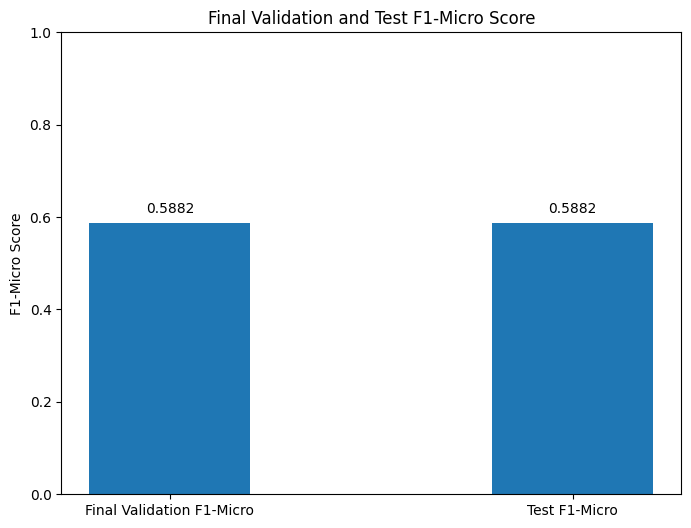

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract evaluation metrics from the trainer's history
# We are now using multi-label metrics, so look for 'eval_f1_micro'
eval_logs = [log for log in trainer.state.log_history if 'eval_f1_micro' in log]

# Get the final validation F1-Micro (from the last epoch)
final_eval_f1_micro = eval_logs[-1]['eval_f1_micro'] if eval_logs else 0.0

# Get the test F1-Micro
# Access the correct key from the test_metrics dictionary
test_f1_micro = test_metrics.get('eval_f1_micro', 0.0)

# Data for the bar plot
labels = ['Final Validation F1-Micro', 'Test F1-Micro']
metrics_values = [final_eval_f1_micro, test_f1_micro]

x = np.arange(len(labels))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, metrics_values, width=0.4)
plt.ylabel('F1-Micro Score')
plt.title('Final Validation and Test F1-Micro Score')
plt.xticks(x, labels)
plt.ylim(0, 1) # Scores are between 0 and 1

# Add metric values on top of the bars
for index, value in enumerate(metrics_values):
    plt.text(index, value + 0.02, str(round(value, 4)), ha='center')


plt.show()

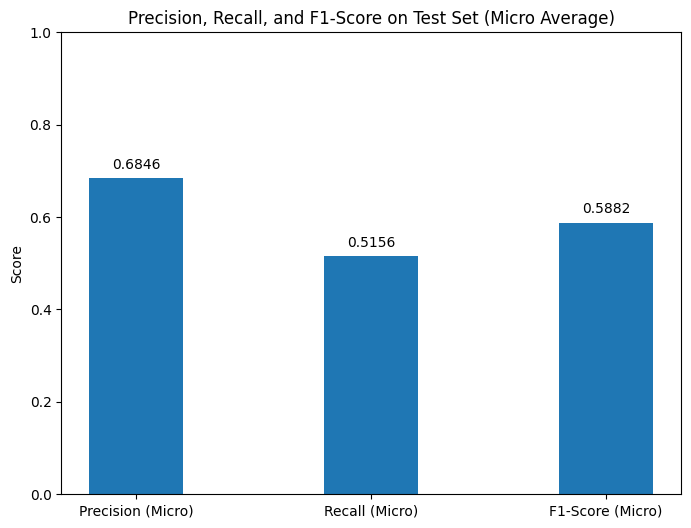

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import torch

# Get predictions on the test set
predictions_output = trainer.predict(goemo_tok["test"])
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to predictions (0 or 1) using a 0.5 threshold, same as in compute_metrics
sigmoid = torch.sigmoid(torch.tensor(logits, dtype=torch.float32))
predictions = (sigmoid > 0.5).numpy().astype(int)

# Calculate micro precision, recall, and f1-score (appropriate for multi-label)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    labels,
    predictions,
    average='micro',
    zero_division=0
)

# Data for the bar plot
metrics_labels = ['Precision (Micro)', 'Recall (Micro)', 'F1-Score (Micro)']
metrics_values = [precision_micro, recall_micro, f1_micro]

x = np.arange(len(metrics_labels))

plt.figure(figsize=(8, 6))
plt.bar(x, metrics_values, width=0.4)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score on Test Set (Micro Average)')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1)

# Add values on top of the bars
for index, value in enumerate(metrics_values):
    plt.text(index, value + 0.02, str(round(value, 4)), ha='center')

plt.show()